In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Синтетические данные

In [80]:
def generate_data(x, weights=np.pi, fn=None, b=0):
    """Генеририем данные"""
    
    fn = fn or (lambda x: x)
    weights = np.atleast_1d(weights)
    
    x = np.sum([ai*np.power(x, i+1) for i, ai in enumerate(weights)], axis=0)
    return fn(x+b)

def noises(shape, power):
    """Random noises for each point"""
    
    return np.random.randn(*shape) * power

def make_dataset(weights, b, fn=None, N=250, x_max=1, noise_power=0, random_x=True, seed=42):
    """Generate polluted dataset"""
    
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N)) * x_max    
    else:
        x = np.linspace(0, x_max, N)
    
    y_true = np.array([])
    
    for f_ in np.append([], fn):
        y_true = np.append(y_true, generate_data(x, weights, f_, b))
        
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape, power=noise_power)
    
    return y, y_true, np.atleast_2d(x).T

### Visualize data

 ### сгенерируем полином второй степени

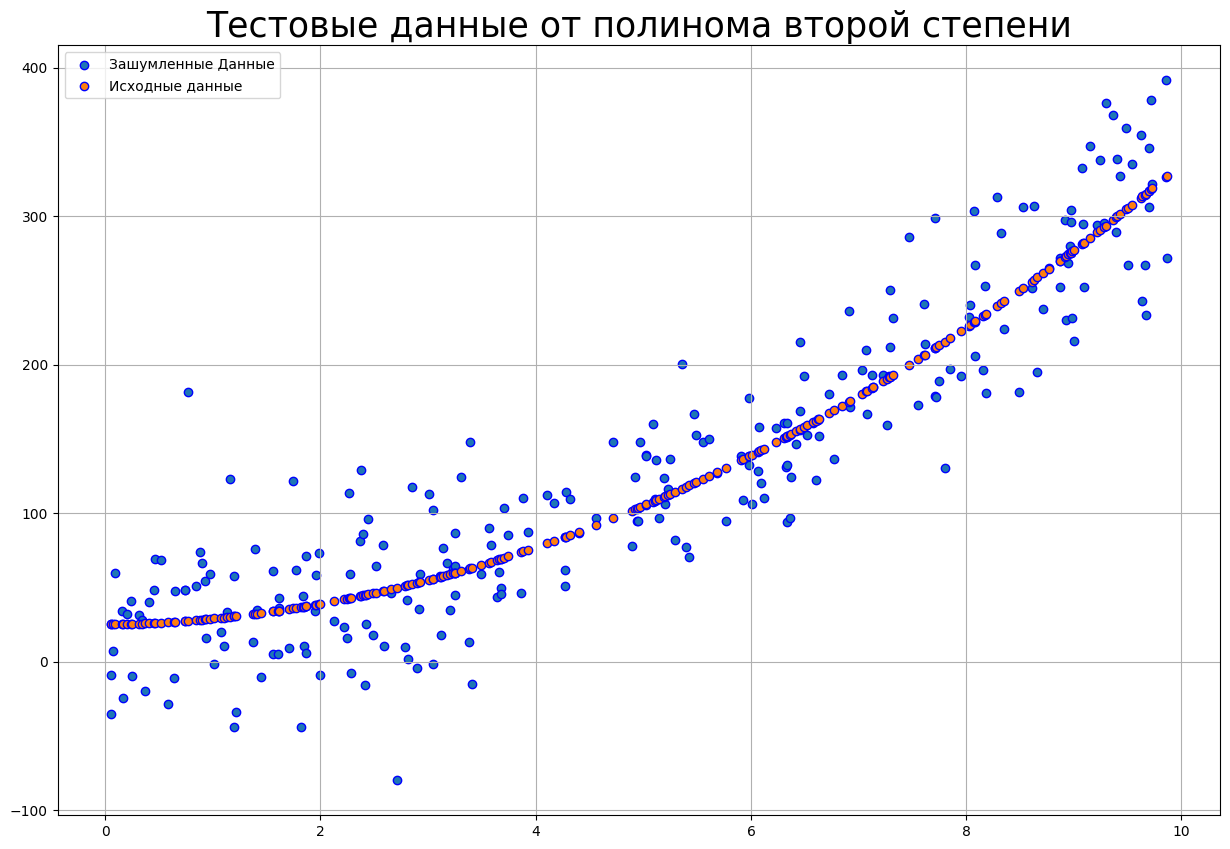

In [81]:
def vis_dataset(y, y_true, x, title):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(x[:, 0], y, edgecolor='b', label="Зашумленные Данные")
    ax.scatter(x[:, 0], y_true, edgecolor='b', label="Исходные данные")
    ax.grid()
    ax.legend()
    ax.set_title(title, fontsize=25)
    
second_order_polynom_dataset = make_dataset([1, 3], b=25, x_max=10, noise_power=40)
vis_dataset(*second_order_polynom_dataset,
            title='Тестовые данные от полинома второй степени')

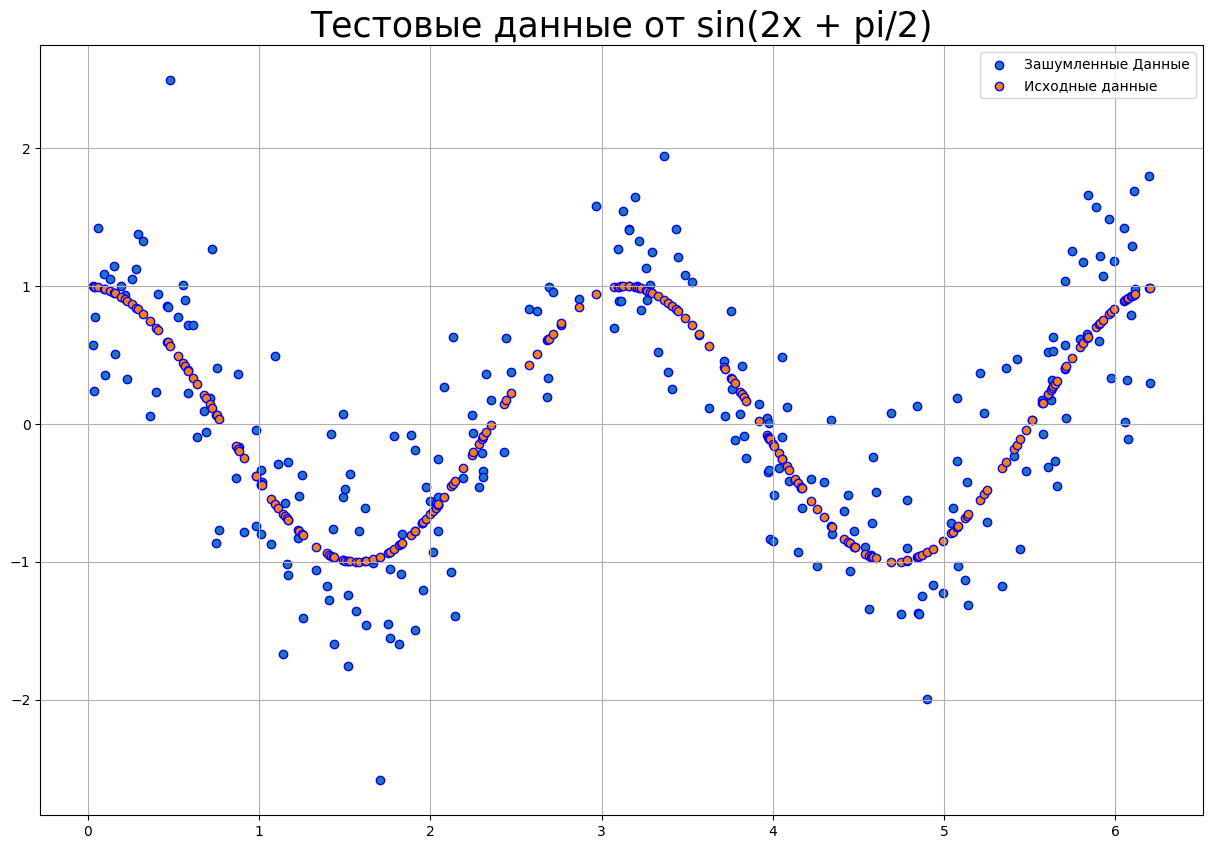

In [82]:
sin2x_withoffset_dataset = make_dataset(2, b=np.pi/2, fn=np.sin, x_max=np.pi*2, noise_power=0.5)

vis_dataset(*sin2x_withoffset_dataset,
            title='Тестовые данные от sin(2x + pi/2)')

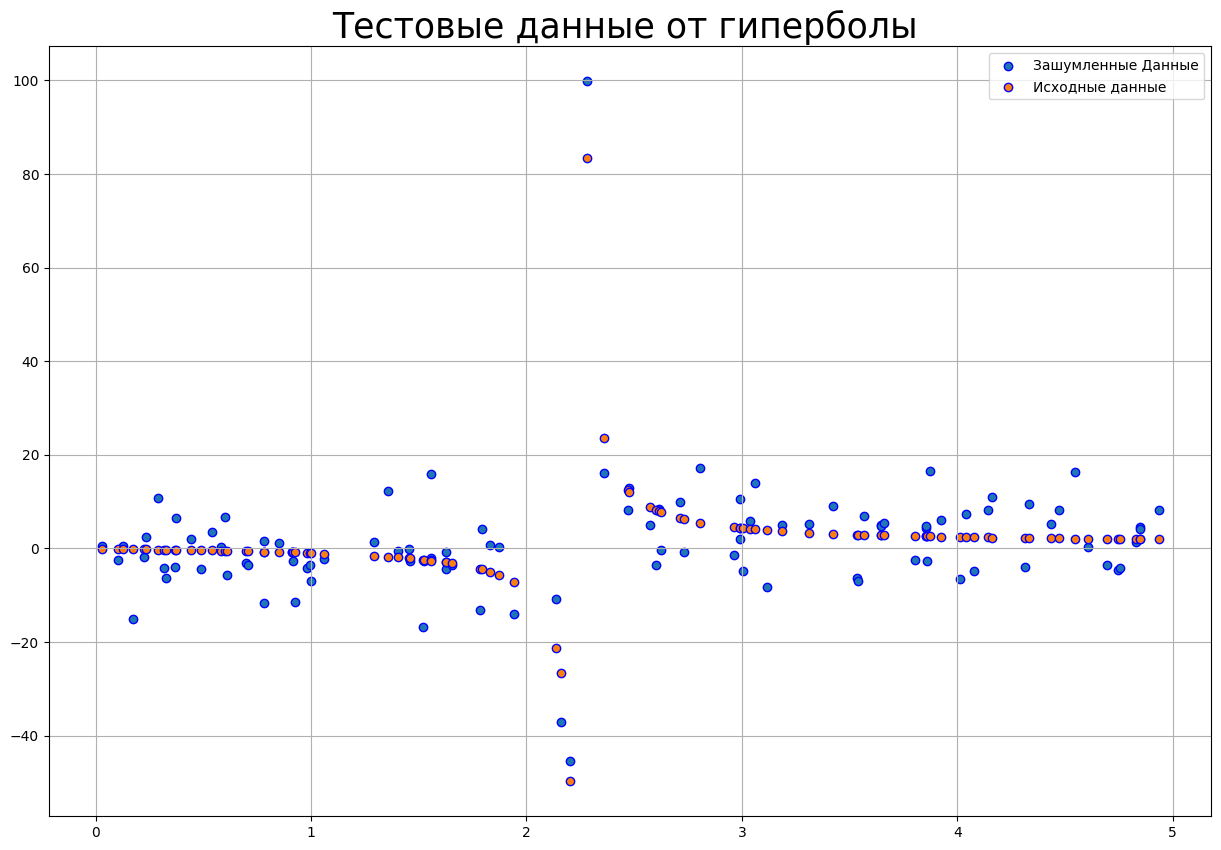

In [83]:
x_max = 5
def hyperbola(x):
    return x/(x - x_max/2)
hyperbola_dataset = make_dataset(weights=1, b=0.25, fn=hyperbola, noise_power=7.5, x_max=x_max, N=100)
vis_dataset(*hyperbola_dataset,
            title='Тестовые данные от гиперболы ')

### Тут копипаста

In [84]:
def split_train_test(x, y, train_size=None, test_size=None, random_state=42, shuffle=True):
    """Split test and train data"""
    
    if random_state:
        np.random.seed(random_state)
        
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle:
        np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<=1): 
            train_size = 1 - test_size
        else:
            train_size = size - test_size
        test_size = None
    
    if train_size is None or train_size > size:
        train_size = size
        
    if train_size <= 1: 
        train_size *= size
    
    if test_size is not None: 
        if test_size<= 1:
            test_size *= size
        if test_size>size:
            test_size = size-train_size
    else: 
        test_size = 0
    
    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

x_train, y_train,  x_test, y_test = split_train_test(second_order_polynom_dataset[0],
                                                     second_order_polynom_dataset[1],  
                                                     test_size=0.3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((175, 1), (175,), (75, 1), (75,))

In [85]:
def init_weights(W_shape, add_bias=True, random_state=42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [86]:
def predict(X, W, add_bias=True):
    X = X.copy()
    if add_bias:
        X = np.column_stack((np.ones(X.shape[0]), X))

    return np.dot(X, W)

def loss_fn(yhat, y):
    return (yhat - y) ** 2

def grad_loss(y_hat, y, X, add_bias=True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]), X))
    else:
        X_full = X
    
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

In [87]:
y_, _, x_ = second_order_polynom_dataset

weights = init_weights(x_.shape[1])
yhat = predict(x_train[0], weights)
loss = loss_fn(yhat, y_[0])

In [88]:
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

In [89]:
def fit(X, y, learning_rate, epsilon=0.01, epochs=None):
    weights = np.array([init_weights(X.shape[1])])
    epochs_ = epochs or 0
    
    while True:
        yhat = predict(X, weights[-1])
        dy = grad_loss(yhat, y, X)
        weights = np.row_stack((weights, update_weights(dy, weights[-1], learning_rate)))
        
        epochs_ -= 1
        
        if np.abs(dy)[0] < epsilon:
            print('epochs: ', -epochs_)
            return weights[-1], -epochs_
        elif epochs_ == 0:
            print('epochs: ', epochs)
            return weights[-1], dy, epochs

### Проверяем данные

In [90]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.figure(figsize=(15, 10))
    plt.plot(x_train[:,0], 
             predict(x_train, weights),
            '.', 
            label='Предсказание на x_train',
            markersize = 12)
    plt.plot(x_test[:,0], 
             predict(x_test,weights),
            'o', 
            label='Предсказание на x_test',
            markersize = 12, 
            alpha =0.8)
    plt.plot(x_train[:,0], 
             y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.grid()
    plt.legend(fontsize=16)
    plt.xlabel('x',fontsize=14)
    plt.ylabel('y',fontsize=14);

epochs:  1341


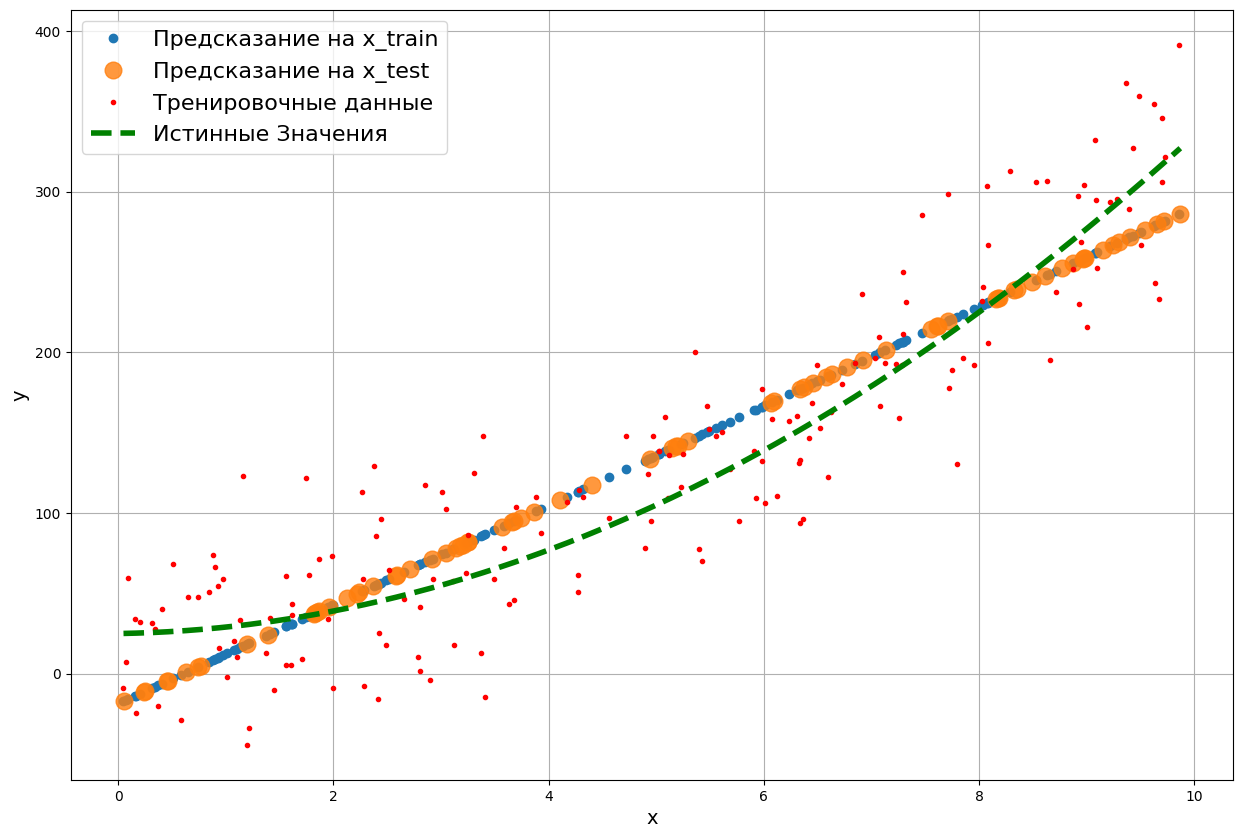

In [91]:
y_, y_true_, x_ = second_order_polynom_dataset
x_train, y_train, x_test, y_test = split_train_test(x_, y_, test_size=0.3)
weights, _ = fit(x_train, y_train, learning_rate=0.01, epochs=None)

plot_model_weights(x_train, y_train, x_test, x_, y_true_, weights)

### В целом подхватили тренд

epochs:  14


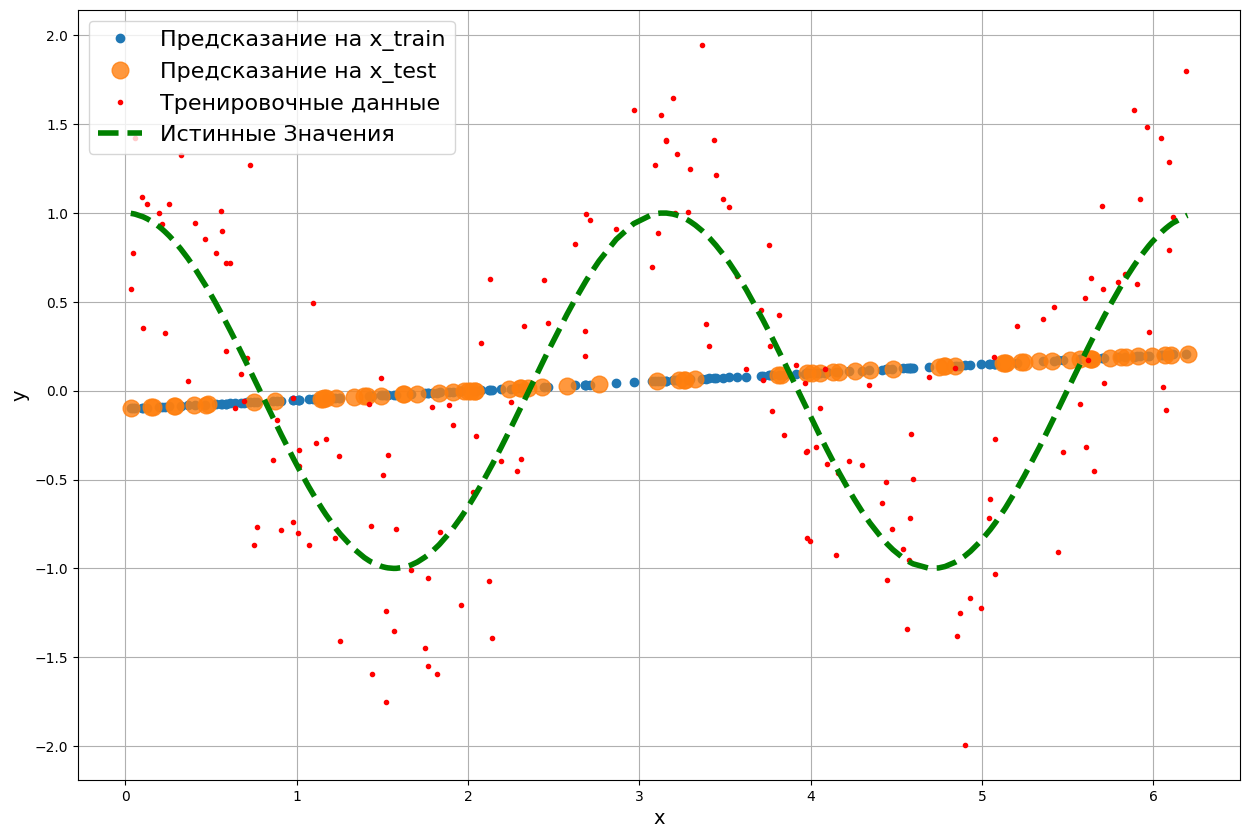

In [92]:
y_, y_true_, x_ = sin2x_withoffset_dataset
x_train, y_train, x_test, y_test = split_train_test(x_, y_, test_size=0.3)
weights, _ = fit(x_train, y_train, learning_rate=0.01, epochs=None)

plot_model_weights(x_train, y_train, x_test, x_, y_true_, weights)

### Линейная функция не сможет такое переварить

epochs:  917


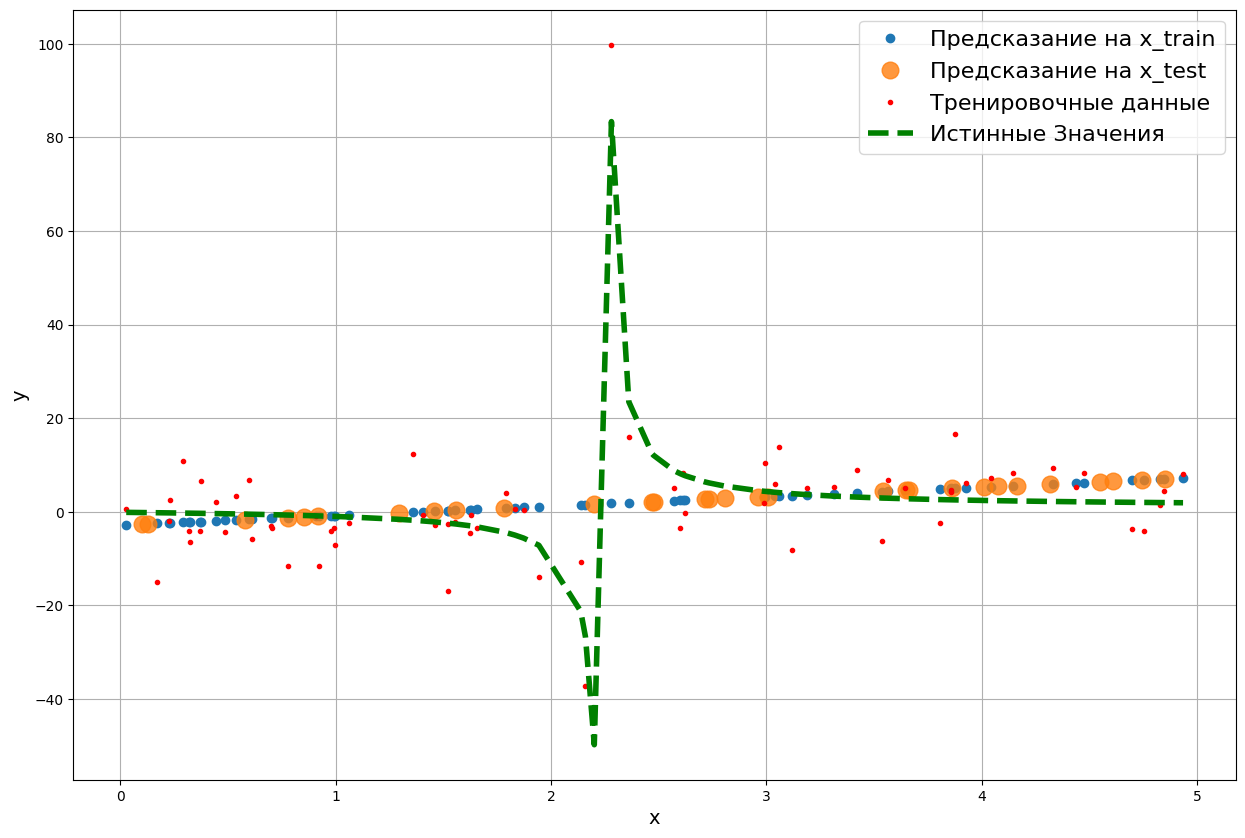

In [93]:
y_, y_true_, x_ = hyperbola_dataset
x_train, y_train, x_test, y_test = split_train_test(x_, y_, test_size=0.3)
weights, _ = fit(x_train, y_train, learning_rate=0.01, epochs=None)

plot_model_weights(x_train, y_train, x_test, x_, y_true_, weights)

### Здесь линейная функция в целом неплоха, но из-за смещения есть восходящий тренд, 
### а по идее аппроксимация должна быть около 0 по ординате

### Для полиномиального анализа будем использовать sklearn и вспомогательные методы

In [94]:
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [95]:
def plot_sklearn_model(x_train, y_train, x_test, x, y, model, title=''):
    plt.plot(x_train[:,0], 
             model.predict(x_train),
            '.', 
            label='Предсказание на x_train',
            markersize = 12)
    plt.plot(x_test[:,0], 
             model.predict(x_test),
            'o', 
            label='Предсказание на x_test',
            markersize = 6, 
            alpha =0.6)
    plt.plot(x_train[:,0], 
             y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.grid()
    plt.legend(fontsize=8)
    plt.title(title)
    plt.xlabel('x',fontsize=14)
    plt.ylabel('y',fontsize=14);

MSE without regularization:  1451.1497518543338
MSE with LASSO regularization:  1451.151559970042


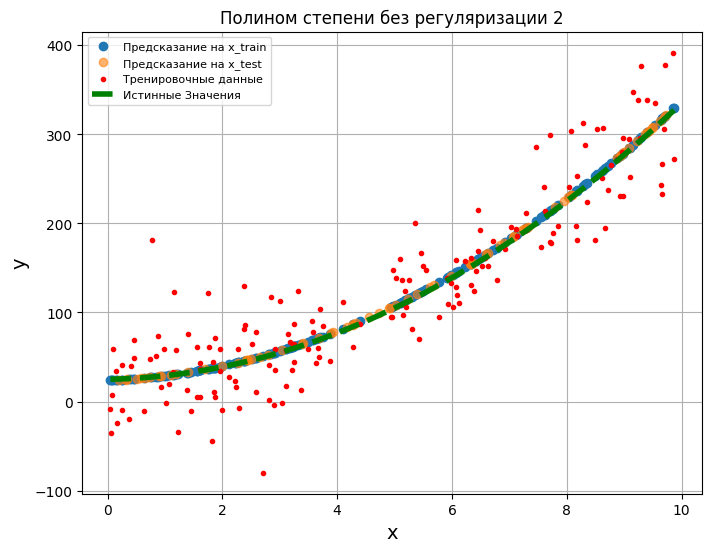

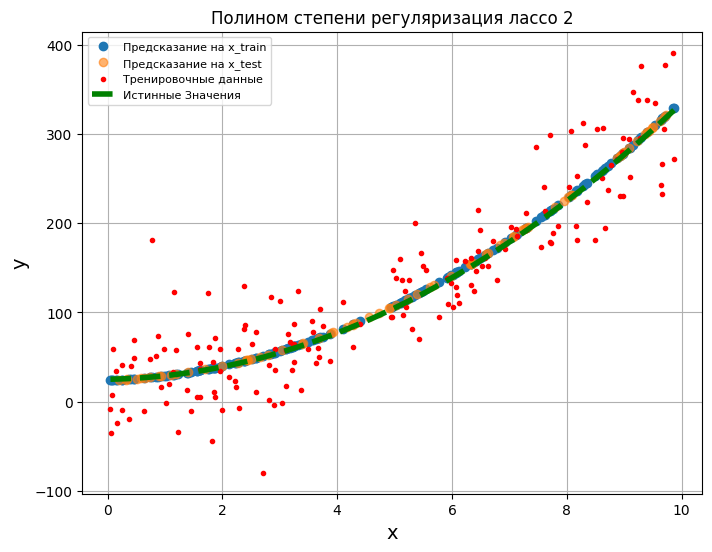

In [96]:
y_, y_true_, x_ = second_order_polynom_dataset
X_train, X_test, y_train, y_test = split(x_, y_, test_size=0.3, random_state=42)

degree = 2

polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train,y_train)
plt.figure(figsize=(8, 6))
plot_sklearn_model(X_train, y_train, X_test, x_, y_true_, polyreg,
                   title=f'Полином степени без регуляризации {degree}')
mse_non_regularized_model = mse(y_test, polyreg.predict(X_test))

# Полином второй степени вполне себе справляется

polyreg=make_pipeline(PolynomialFeatures(degree), Lasso(alpha=2e-4, max_iter=10000))
polyreg.fit(X_train,y_train)
plt.figure(figsize=(8, 6))
plot_sklearn_model(X_train, y_train, X_test, x_, y_true_, polyreg, 
                   title=f'Полином степени регуляризация лассо {degree}')
mse_regularized_model = mse(y_test, polyreg.predict(X_test))

# Практически идентичные метрики
print('MSE without regularization: ', mse_non_regularized_model)
print('MSE with LASSO regularization: ', mse_regularized_model)

MSE without regularization, degree(4):  0.42125667359730234
MSE without regularization, degree(5):  0.4399879245104758
MSE without regularization, degree(6):  0.23455456681597822
MSE with RIDGE regularization, degree(4):  0.4239775337823831
MSE with RIDGE regularization, degree(5):  0.44329492418902655
MSE with RIDGE regularization, degree(6):  0.234911747727374


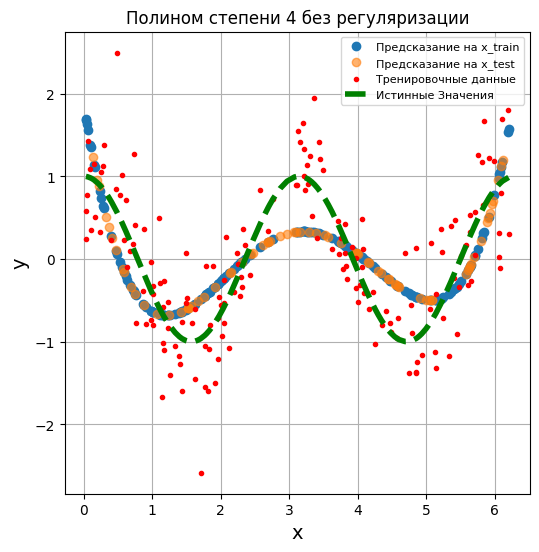

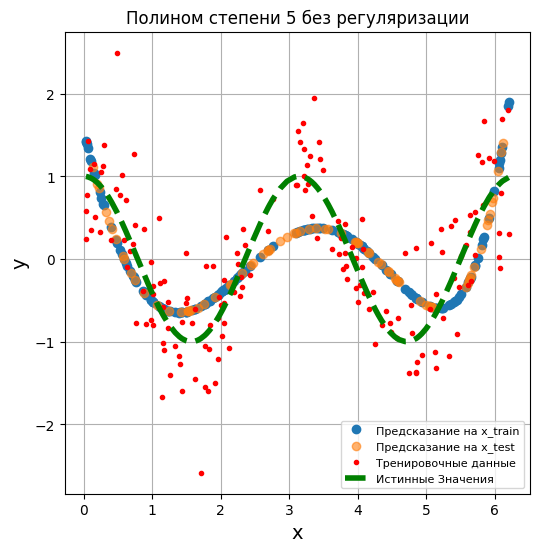

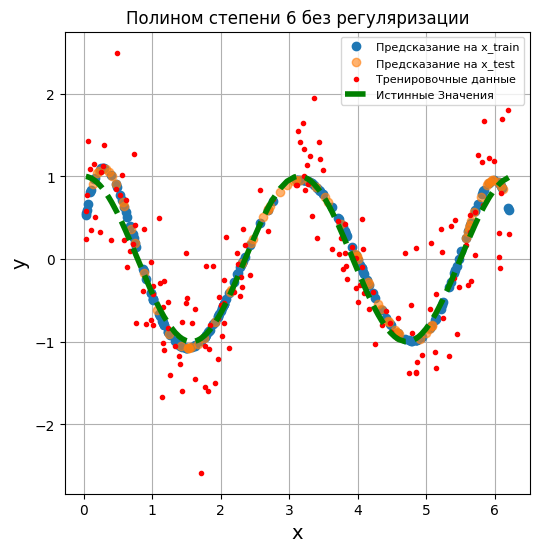

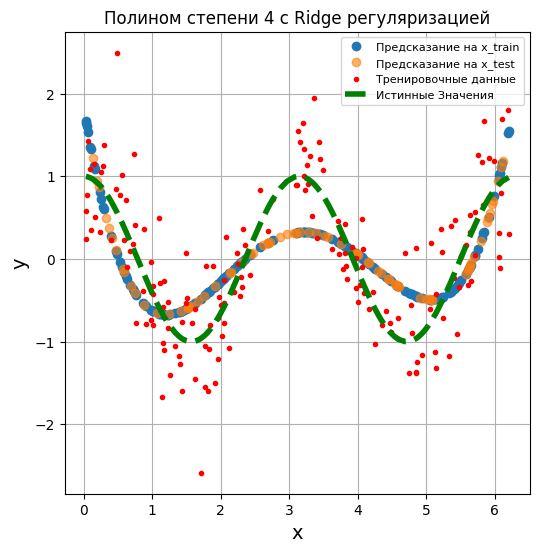

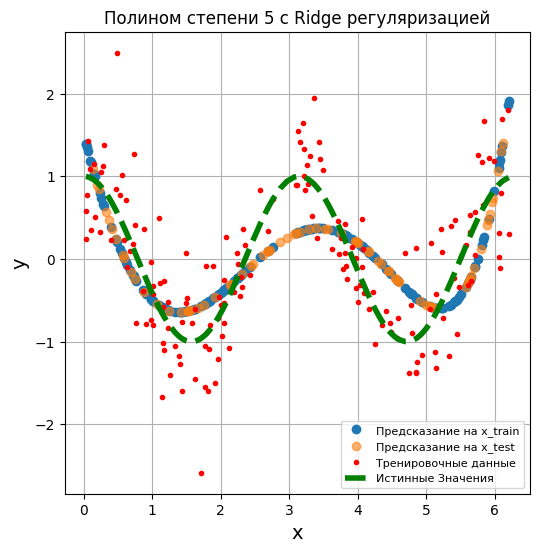

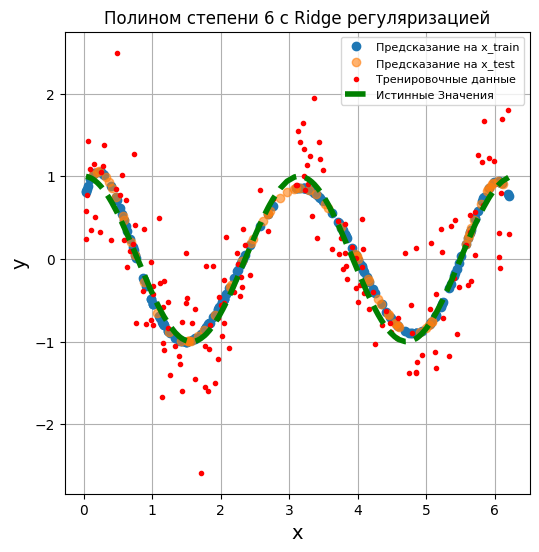

In [97]:
y_, y_true_, x_ = sin2x_withoffset_dataset
X_train, X_test, y_train, y_test = split(x_, y_, test_size=0.3, random_state=42)

for degree in [4, 5, 6]:
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(X_train, y_train)
    plt.figure(figsize=(6, 6))
    plot_sklearn_model(X_train, y_train, X_test, x_, y_true_, polyreg, 
                       title=f'Полином степени {degree} без регуляризации')
    
    mse_non_regularized_model = mse(y_test, polyreg.predict(X_test))
    print(f'MSE without regularization, degree({degree}): ', mse_non_regularized_model)
    
## Полиномы 4 и 5 степени неплохо апроксимирует, но можно лучше - 6 степень полином идеально справляется

for degree in [4, 5, 6]:
    polyreg=make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.02, max_iter=10_000))
    polyreg.fit(X_train,y_train)
    plt.figure(figsize=(6, 6))
    plot_sklearn_model(X_train, y_train, X_test, x_, y_true_, polyreg, 
                       title=f'Полином степени {degree} c Ridge регуляризацией')
    
    mse_regularized_model = mse(y_test, polyreg.predict(X_test))
    print(f'MSE with RIDGE regularization, degree({degree}): ', mse_regularized_model)
    
### Также практически идентичные ошибки

MSE without regularization, degree(2):  38.051318256937975
MSE without regularization, degree(3):  35.787532504304004
MSE without regularization, degree(4):  40.37162780487872
MSE with regularization, degree(3):  36.06142907373788


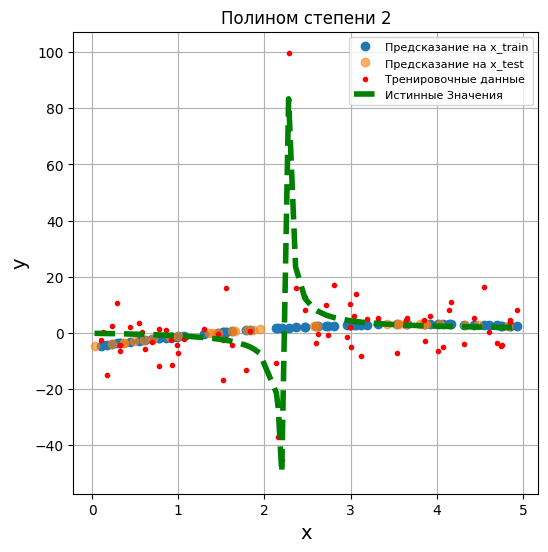

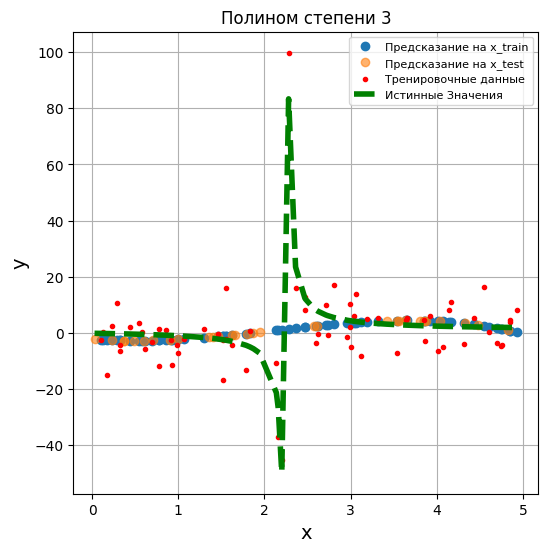

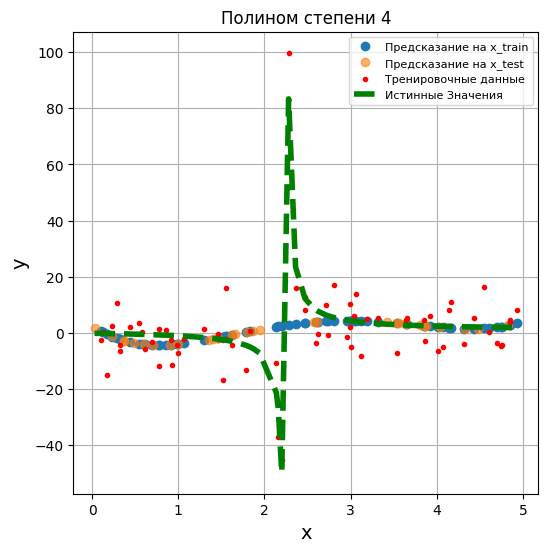

In [98]:
y_, y_true_, x_ = hyperbola_dataset
X_train, X_test, y_train, y_test = split(x_, y_, test_size=0.3, random_state=42)

for degree in [2, 3, 4]:
    polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(X_train,y_train)
    
    plt.figure(figsize=(6, 6))
    plot_sklearn_model(X_train, y_train, X_test, x_, y_true_, polyreg, title=f'Полином степени {degree}')
    
    mse_ = mse(y_test, polyreg.predict(X_test))
    print(f'MSE without regularization, degree({degree}): ', mse_)

## Полиномы 3 степени справляется лучше, чем [2, 4], тк у них есть перегибы через единицу после ассимптоты с обоих сторон

polyreg=make_pipeline(PolynomialFeatures(3), Lasso(alpha=0.015, max_iter=10_000))
polyreg.fit(X_train,y_train)
mse_ = mse(y_test, polyreg.predict(X_test))
print(f'MSE with regularization, degree(3): ', mse_)

## В целом здесь также регуляризация не особа помагает

# Исследуем набор данных Cars Moldova

In [99]:
cars_df = pd.read_csv('datasets/enriched_df.csv', sep=',')
cars_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Distance_description,Price_frequence,mean_price_deviation
12332,Ford,Fusion,2017,Sedan,58000.0,1998.0,Petrol,Automatic,13190.0,4,14500.000000,с небольшим пробегом,frequent mid,0.300
4047,Mercedes,E Class,2008,Universal,310000.0,2200.0,Diesel,Manual,8000.0,13,23846.153846,с большим пробегом,frequent mid,-0.264
22193,Opel,Zafira,2000,Minivan,4645.0,1600.0,Metan/Propan,Manual,1500.0,21,221.190476,с небольшим пробегом,frequent cheap,-0.645
16306,Suzuki,Vitara,2015,Crossover,70000.0,1400.0,Petrol,Automatic,14450.0,6,11666.666667,с небольшим пробегом,frequent mid,0.168
25677,Renault,Megane,2005,Universal,315000.0,1600.0,Petrol,Manual,1200.0,16,19687.500000,с большим пробегом,frequent cheap,-0.786


In [100]:
# Utils

PROPOSED_DEGREE = 3

def draw_graph(*, y_test, predictions, title='График предсказаний цены авто', plot_batch_size=100):
    plt.figure(figsize=(10, 8))
    plt.scatter(np.arange(plot_batch_size), y_test[0:plot_batch_size], label='true', alpha=0.5)
    plt.scatter(np.arange(plot_batch_size), predictions[0:plot_batch_size], label='predict', alpha=0.7)
    plt.legend()
    plt.title(title)
    
def display_metrics(y_test, predictions):
    mse_ = mse(y_test, predictions)
    print('RMSE: ', mse_ ** (1/2))
    
    r2 = r2_score(y_test, predictions)
    print('Determination coefficient: ', r2)

/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e+11, tolerance: 1.769e+08
  model = cd_fast.enet_coordinate_descent(
/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_79826/1643941957.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(np.arange(plot_batch_size), y_test[0:plot_batch_size], label='true', alpha=0.5)


RMSE:  4402.231539236603
Determination coefficient:  0.7434048550244231


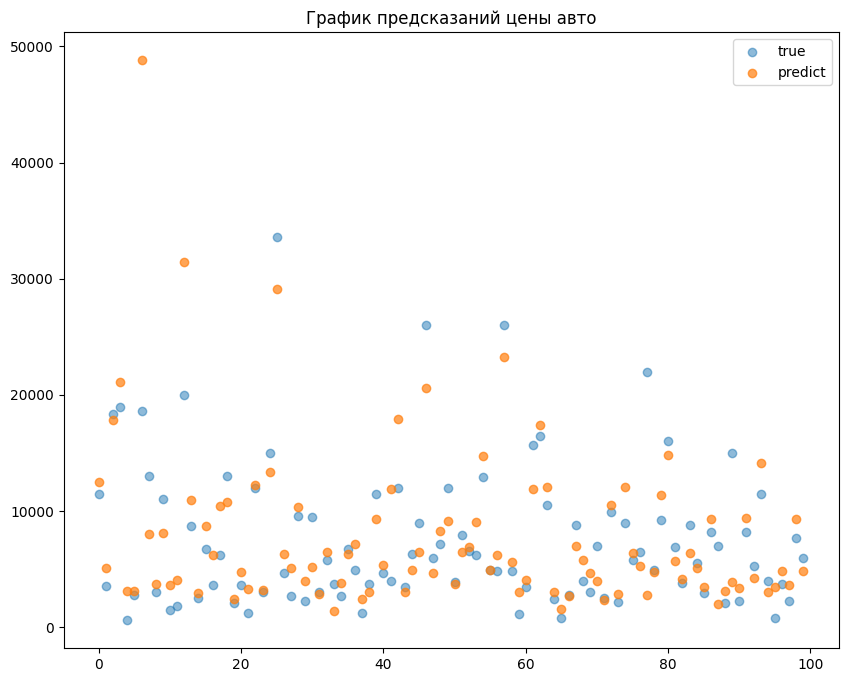

In [101]:
# Подготовим данные

features = ['Age', 'Transmission', 'km_year', 'frequent', 'rare', 'Engine_capacity(cm3)']
target = 'Price(euro)'

rare_models_mask = cars_df['Model'].value_counts()
cars_df['frequence'] = (cars_df['Model'].transform(lambda x: 'rare' if rare_models_mask[x] < 20 else 'frequent'))
cars_df = pd.concat((cars_df, pd.get_dummies(cars_df['frequence'])), axis=1)

cars_df['Transmission'] = cars_df['Transmission'].transform(lambda x: 1 if x == 'Manual' else 3)

cars_df = cars_df.dropna(how='any')

### Проверим данные

X_train, X_test, y_train, y_test = split(cars_df[features], cars_df[target], test_size=0.25, random_state=42)

model = make_pipeline(PolynomialFeatures(degree=PROPOSED_DEGREE), Lasso(alpha=5E-8, max_iter=1000))
model.fit(X_train, y_train)

predictions = model.predict(X_test)

draw_graph(y_test=y_test, predictions=predictions)
display_metrics(y_test=y_test, predictions=predictions) # Не все так плохо)

#### Выводы:
- В целом кажется какой-то тренд верхнеуровневого мы подхватили, но по ощущениям как будто бы какой-то один признак для дорогих авто портит предсказания модели. По ощущениям если отсечь дорогие авто будет лучше
- Ошибка осталось недопустимой, 5 тысяч в среднем эт оч много, хотя я так понимаю тут оч сильно влияют ошибки при предсказании дорогих авто
- Стоит посмотреть метрики которые менее чувствительны к выбросам. Попробуем R2

/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e+11, tolerance: 1.265e+08
  model = cd_fast.enet_coordinate_descent(
/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_79826/1643941957.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(np.arange(plot_batch_size), y_test[0:plot_batch_size], label='true', alpha=0.5)


RMSE:  3773.860171352133
Determination coefficient:  0.7539367910358458


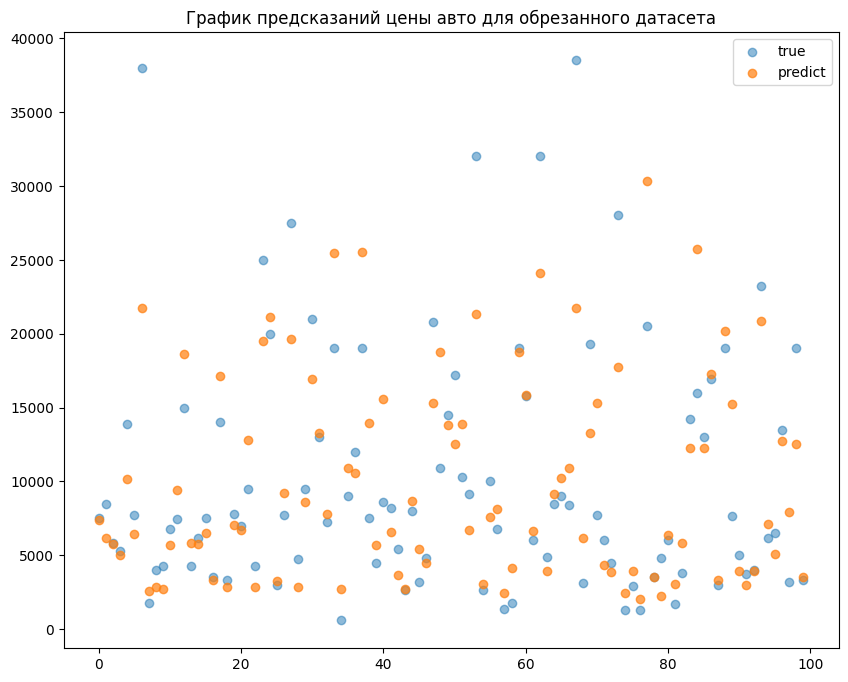

In [102]:
# Хочется проверить модель без дорогих авто
cars_df_cutted = cars_df.copy()
cars_df_cutted = cars_df_cutted.drop(cars_df_cutted.index[cars_df_cutted[target] > 50_000])

# Ниже Copypaste (Нужно бы вынести в отедльный метод)

X_train, X_test, y_train, y_test = split(cars_df_cutted[features], 
                                         cars_df_cutted[target], 
                                         test_size=0.25, 
                                         random_state=42)

winner_model = make_pipeline(PolynomialFeatures(degree=PROPOSED_DEGREE), Lasso(alpha=5E-8, max_iter=1000))

winner_model.fit(X_train, y_train)
predictions = winner_model.predict(X_test)

draw_graph(y_test=y_test, predictions=predictions, title='График предсказаний цены авто для обрезанного датасета')
display_metrics(y_test=y_test, predictions=predictions)

# Вывод - гипотеза имеет место быть, избавившись от дорогих авто - mse и r2 стало  лучше

### Попробуем разные методы препроцессинга признаков

/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+11, tolerance: 1.769e+08
  model = cd_fast.enet_coordinate_descent(
/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_79826/1643941957.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(np.arange(plot_batch_size), y_test[0:plot_batch_size], label='true', alpha=0.5)


RMSE:  4409.424919691441
Determination coefficient:  0.7425656013323365


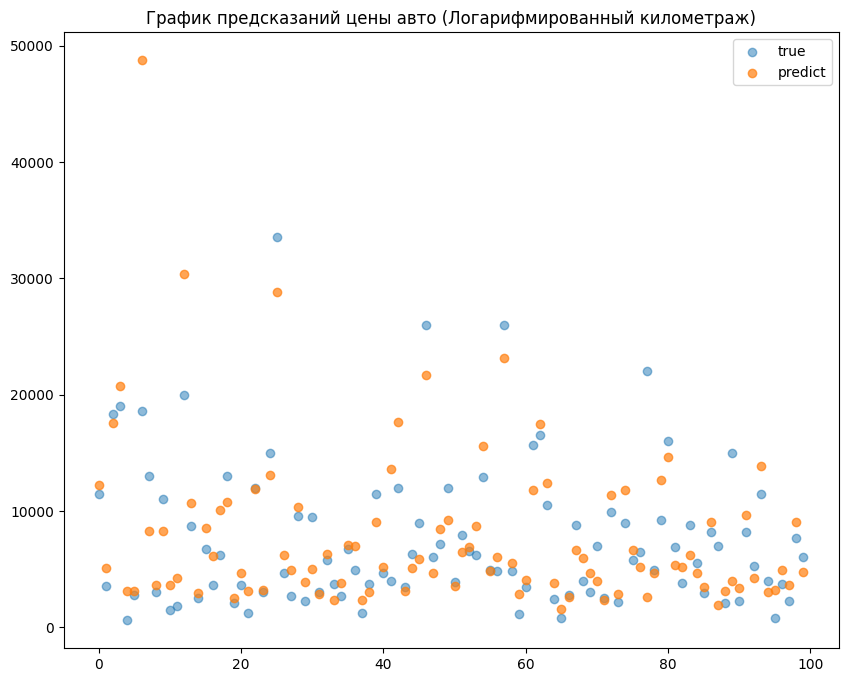

In [103]:
from sklearn.preprocessing import FunctionTransformer

cars_df_log = cars_df.copy()

transformer = FunctionTransformer(np.log1p, validate=True)
cars_df_log['km_year'] = transformer.fit_transform(cars_df_log[['km_year']])

X_train, X_test, y_train, y_test = split(cars_df_log[features], cars_df_log[target], test_size=0.25, random_state=42)

model = make_pipeline(PolynomialFeatures(degree=PROPOSED_DEGREE), Lasso(alpha=5E-8, max_iter=1000))
model.fit(X_train, y_train)

predictions = model.predict(X_test)

draw_graph(y_test=y_test, predictions=predictions, title='График предсказаний цены авто (Логарифмированный километраж)')
display_metrics(y_test=y_test, predictions=predictions)

# Логарифмировать километраж оказалось не особо результативной идеей, 
# хотя из первой практике казалось, что распределение km_year похоже на экспоненциальное со смещением в начале

/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e+11, tolerance: 1.769e+08
  model = cd_fast.enet_coordinate_descent(
/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_79826/1643941957.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(np.arange(plot_batch_size), y_test[0:plot_batch_size], label='true', alpha=0.5)


RMSE:  4403.0118181082025
Determination coefficient:  0.7433138859274373


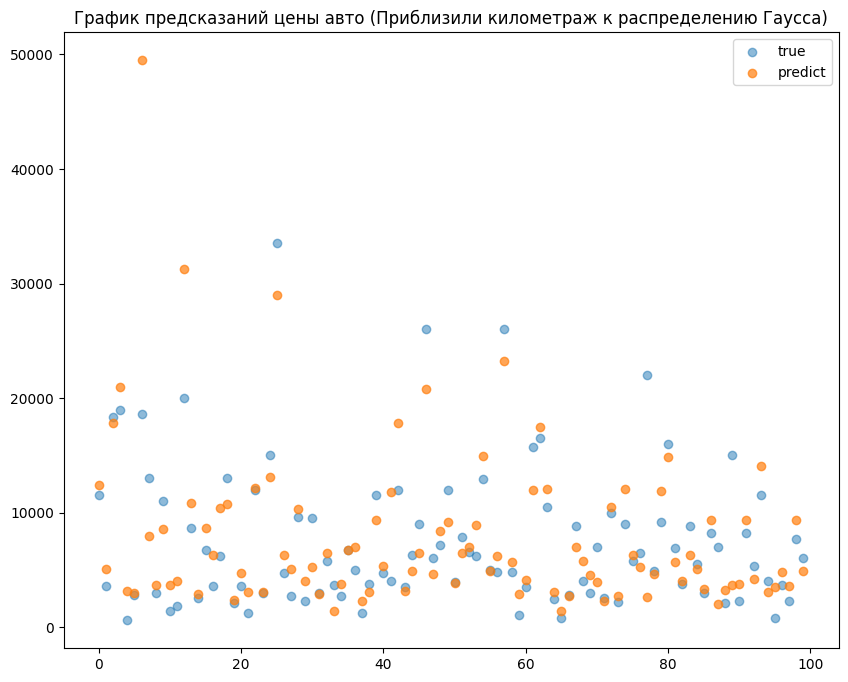

In [104]:
from sklearn.preprocessing import PowerTransformer

cars_df_gaussian = cars_df.copy()

transformer = PowerTransformer()
cars_df_gaussian['km_year'] = transformer.fit_transform(cars_df_gaussian[['km_year']])

X_train, X_test, y_train, y_test = split(cars_df_gaussian[features], cars_df_gaussian[target], 
                                         test_size=0.25, random_state=42)

model = make_pipeline(PolynomialFeatures(degree=PROPOSED_DEGREE), Lasso(alpha=5E-8, max_iter=1000))
model.fit(X_train, y_train)

predictions = model.predict(X_test)

draw_graph(y_test=y_test, predictions=predictions, 
           title='График предсказаний цены авто (Приблизили километраж к распределению Гаусса)')
display_metrics(y_test=y_test, predictions=predictions)

# Значительных изменений нет(


In [108]:

feature_names_out = list(winner_model.steps[0][1].get_feature_names_out())
weights_indices = [feature_names_out.index(feature) for feature in features]
print('Verify Features names: ', [feature_names_out[index] for index in weights_indices])
print('Initial features weights: ', [winner_model.steps[1][1].coef_[index] for index in weights_indices])
print('Intercept: ', winner_model.steps[1][1].intercept_)

# Подведем итоги:
# Модель увидела зависимость от трансмиссии, полагаю авто с автоматом на ~ тысячи дороже по мнению модели
# отрицательно влияет возраст,
# положительно влияет объем двигателя,
# получился странный коэффициент у километража,
# не влияет как часто или редко встречается авто - можно исключить из модели
#
# В следующий раз надо делать больший упор на feature-engineering

Verify Features names:  ['Age', 'Transmission', 'km_year', 'frequent', 'rare', 'Engine_capacity(cm3)']
Initial features weights:  [-64.43998891468996, 3104.415750968387, 0.05709781201482886, 0.0, 0.0, 8.265411631527154]
Intercept:  3027.6681326047164
